# Autoencoder 2.0

## Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras.applications import mobilenet
from keras.layers import Input, Dense, ReLU, LeakyReLU, GlobalAveragePooling2D, Reshape
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  1


Variables globales

In [2]:
ruta = "autoencoder2.0"
nombre = "autoencoder2.0_15000e"

Creamos las carpetas para almacenar el output

In [3]:
try:
    os.mkdir(ruta)
except OSError:
    print("Carpeta %s ya existe" % (ruta))
try:
    os.mkdir(ruta+"/output")
except OSError:
    print("Carpeta %s ya existe" % (ruta+"/output"))

Carpeta autoencoder2.0 ya existe
Carpeta autoencoder2.0/output ya existe


Funcion para extraer los datos de los ficheros

In [4]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [5]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [6]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [7]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


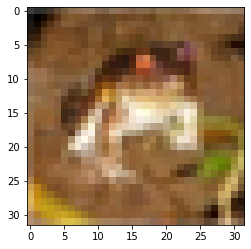

In [8]:
plt.imshow(imagen)

## Preparacion de los datos

Cargamos todas las imagenes de entrenamiento en la variable ``X_train`` y borramos todo lo demás ya que no lo vamos a utilizar.

In [9]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
del batch1
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
del batch2
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
del batch3
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
del batch4
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
del batch5
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

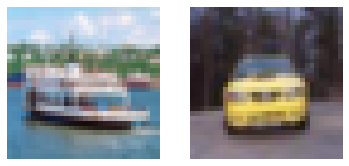

In [10]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])
for a in arrx:
    a.axis("off")

## Arquitectura del ``Autoencoder``

Tamaño de la capa latente:

In [11]:
dim_latente = 20

Tamaño de las imagenes:

In [12]:
img_shape = X_train[0].shape

### Regla de la piramide geometrica

La regla de la piramide geometrica sirve para ayudar determinar el tamaño de las capas ocultas en base al tamaño de las capas de input y output y al numero de capas ocultas. 

Esta aproximacion esta propuesta por Masters(1993): 
>  "For a three layer network with n input and m output neurons, the hidden layer would have sqrt(N * M) neurons."
>
> -- <cite> Masters, Timothy. Pratical neural network recipes in C++. Morgan Kaufmann, 1993.</cite>

[Enlace al artículo](https://eulertech.wordpress.com/2018/01/02/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-network/)

In [13]:
def pyramid_rule(h_layers, input_size, output_size):
    if h_layers < 1:
        print("No layers")
        return
    print("Layers for input %d and output %d:" % (input_size,  output_size))
    rate = (input_size/output_size)**(1/(h_layers+1))
    for l in range(h_layers):
        layer_size = output_size*(rate**(h_layers-l))
        layer_size = round(layer_size)
        print("Layer %d: %d neurons" % (l+1, layer_size))
    return

### EMD(Earth Mover's Distance)

EMD es una medida de distancia entre distribuciones de probabilidad, que consiste en representar ambas distribuciones como montones de tierra, en los que la distancia se determina en cuanto es el trabajo minimo que llevaria transformar un monticulo en otro. Matematicamente a EMD se la conoce como la métrica de Wasserstein.

Segun [este artículo](https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/) esta metrica se puede aplicar de la siguiente manera:

In [14]:
def wasserstein_loss(y_true, y_pred):
	return keras.backend.mean(y_true * y_pred)

### Encoder

El ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_encoder(dim_latente, img_shape):
    inputs = Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = mobilenet.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    #core.trainable = False
    model = core(x, training=False)
    model = GlobalAveragePooling2D()(model)
    repr_latente = keras.layers.Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


### Decoder

El ``decoder`` toma la codificacion latente y decodifica en una imagen. En este caso vamos a utilizar la regla de la piramide geometrica para determinar las capas, en este caso van a ser 2 capas ocultas.

In [16]:
pyramid_rule(2, dim_latente, np.prod(img_shape))

Layers for input 20 and output 3072:
Layer 1: 107 neurons
Layer 2: 574 neurons


In [17]:
def build_myDecoder(dim_latente, img_shape):
    model = keras.Sequential()
    model.add(Dense(107, input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(574))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation=keras.activations.tanh))
    #model.add(ReLU())
    model.add(Reshape(img_shape))
    z = Input(shape=(dim_latente))
    img =  model(z)
    return keras.Model(z,img)

### Red completa

Parametros

In [18]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)
#loss=wasserstein_loss
loss="mse"

Encoder y decoder

In [19]:
encoder = build_encoder(dim_latente, img_shape)
decoder = build_myDecoder(dim_latente, img_shape)

Autoencoder

In [20]:
# el encoder toma un imagen y la codifica y el decoder toma la codificacion e intenta regenerar la imagen
img = Input(shape=img_shape)
encoded = encoder(img)
reconstructed = decoder(encoded)

# Autoencoder
autoencoder = keras.Model(img, reconstructed)
autoencoder.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

## Entrenamiento

### Funciones de muestreo

In [21]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    if save_imgs:
        f.savefig(ruta+"/output/"+nombre+"_generationCIFAR10_e%d.png" % (epoch))
        plt.close()
    

### Datos para muestreo visual

In [22]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from.shape

(10000, 3072)

In [23]:
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255

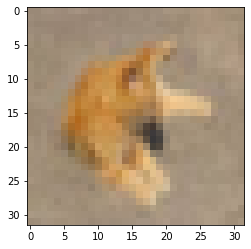

In [24]:
plt.imshow(sample_from[np.random.randint(0,sample_from.shape[0])])

### Ciclo de entrenamiento

In [25]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
epochs=15000
batch_size=120
sample_interval=1000

for epoch in range(epochs+1):
    # lote de imagenes
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # entrenamos al autoencoder
    loss = autoencoder.train_on_batch(imgs,imgs)
    
    # monitorizamos el progreso
    if epoch % 10==0:
        print("Epoch: %d loss = %f, acc = %.2f%%" % (epoch, loss[0], 100*loss[1]))
    # Hacemos una muestra visual
    if epoch % sample_interval==0:
        sample_imgs(sample_from, autoencoder, epoch)


Epoch: 0 loss = 0.286006, acc = 33.11%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 loss = 0.111467, acc = 34.10%
Epoch: 20 loss = 0.064380, acc = 39.19%
Epoch: 30 loss = 0.061432, acc = 40.36%
Epoch: 40 loss = 0.067750, acc = 40.82%
Epoch: 50 loss = 0.057069, acc = 37.90%
Epoch: 60 loss = 0.060577, acc = 43.09%
Epoch: 70 loss = 0.055635, acc = 42.39%
Epoch: 80 loss = 0.053838, acc = 39.32%
Epoch: 90 loss = 0.071024, acc = 40.48%
Epoch: 100 loss = 0.052659, acc = 40.56%
Epoch: 110 loss = 0.053790, acc = 39.62%
Epoch: 120 loss = 0.056967, acc = 43.59%
Epoch: 130 loss = 0.050165, acc = 42.89%
Epoch: 140 loss = 0.052291, acc = 43.01%
Epoch: 150 loss = 0.057791, acc = 39.71%
Epoch: 160 loss = 0.047229, acc = 46.72%
Epoch: 170 loss = 0.050185, acc = 44.30%
Epoch: 180 loss = 0.048501, acc = 46.63%
Epoch: 190 loss = 0.047903, acc = 42.73%
Epoch: 200 loss = 0.050596, acc = 42.18%
Epoch: 210 loss = 0.047726, acc = 45.53%
Epoch: 220 loss = 0.046650, acc = 42.77%
Epoch: 230 loss = 0.042931, acc = 47.13%
Epoch: 240 loss = 0.045618, acc = 41.26%
Epoch: 250 loss = 0.04876

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2010 loss = 0.031613, acc = 53.08%
Epoch: 2020 loss = 0.031044, acc = 54.21%
Epoch: 2030 loss = 0.033153, acc = 50.16%
Epoch: 2040 loss = 0.035538, acc = 52.15%
Epoch: 2050 loss = 0.037326, acc = 49.50%
Epoch: 2060 loss = 0.036065, acc = 55.56%
Epoch: 2070 loss = 0.033608, acc = 49.58%
Epoch: 2080 loss = 0.033755, acc = 48.31%
Epoch: 2090 loss = 0.036159, acc = 49.57%
Epoch: 2100 loss = 0.036925, acc = 50.94%
Epoch: 2110 loss = 0.032618, acc = 48.36%
Epoch: 2120 loss = 0.030141, acc = 52.20%
Epoch: 2130 loss = 0.039825, acc = 49.33%
Epoch: 2140 loss = 0.034458, acc = 51.89%
Epoch: 2150 loss = 0.032382, acc = 52.82%
Epoch: 2160 loss = 0.033716, acc = 54.83%
Epoch: 2170 loss = 0.036616, acc = 52.44%
Epoch: 2180 loss = 0.033523, acc = 50.69%
Epoch: 2190 loss = 0.033433, acc = 53.74%
Epoch: 2200 loss = 0.032020, acc = 58.03%
Epoch: 2210 loss = 0.040787, acc = 56.74%
Epoch: 2220 loss = 0.034786, acc = 54.24%
Epoch: 2230 loss = 0.032529, acc = 53.23%
Epoch: 2240 loss = 0.030802, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10000 loss = 0.021556, acc = 60.12%
Epoch: 10010 loss = 0.024471, acc = 55.51%
Epoch: 10020 loss = 0.023863, acc = 60.20%
Epoch: 10030 loss = 0.022474, acc = 59.19%
Epoch: 10040 loss = 0.023555, acc = 57.37%
Epoch: 10050 loss = 0.024644, acc = 60.76%
Epoch: 10060 loss = 0.029002, acc = 61.48%
Epoch: 10070 loss = 0.026793, acc = 61.10%
Epoch: 10080 loss = 0.024264, acc = 59.57%
Epoch: 10090 loss = 0.022064, acc = 56.65%
Epoch: 10100 loss = 0.021307, acc = 56.05%
Epoch: 10110 loss = 0.023444, acc = 57.40%
Epoch: 10120 loss = 0.025111, acc = 56.88%
Epoch: 10130 loss = 0.024198, acc = 59.56%
Epoch: 10140 loss = 0.024406, acc = 62.84%
Epoch: 10150 loss = 0.024295, acc = 57.28%
Epoch: 10160 loss = 0.022416, acc = 60.18%
Epoch: 10170 loss = 0.025143, acc = 57.36%
Epoch: 10180 loss = 0.023201, acc = 57.33%
Epoch: 10190 loss = 0.022929, acc = 58.08%
Epoch: 10200 loss = 0.023873, acc = 53.86%
Epoch: 10210 loss = 0.022345, acc = 62.81%
Epoch: 10220 loss = 0.024325, acc = 59.43%
Epoch: 1023

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12000 loss = 0.022389, acc = 60.32%
Epoch: 12010 loss = 0.022364, acc = 58.32%
Epoch: 12020 loss = 0.021238, acc = 65.45%
Epoch: 12030 loss = 0.023637, acc = 57.02%
Epoch: 12040 loss = 0.023975, acc = 62.14%
Epoch: 12050 loss = 0.023560, acc = 56.04%
Epoch: 12060 loss = 0.022104, acc = 63.74%
Epoch: 12070 loss = 0.022510, acc = 60.71%
Epoch: 12080 loss = 0.023187, acc = 57.72%
Epoch: 12090 loss = 0.021755, acc = 64.66%
Epoch: 12100 loss = 0.023175, acc = 66.78%
Epoch: 12110 loss = 0.021908, acc = 57.09%
Epoch: 12120 loss = 0.024826, acc = 55.83%
Epoch: 12130 loss = 0.022056, acc = 61.13%
Epoch: 12140 loss = 0.022770, acc = 55.21%
Epoch: 12150 loss = 0.022897, acc = 58.96%
Epoch: 12160 loss = 0.024874, acc = 53.05%
Epoch: 12170 loss = 0.022830, acc = 61.43%
Epoch: 12180 loss = 0.023048, acc = 57.43%
Epoch: 12190 loss = 0.022666, acc = 60.82%
Epoch: 12200 loss = 0.024593, acc = 66.78%
Epoch: 12210 loss = 0.022182, acc = 59.27%
Epoch: 12220 loss = 0.022134, acc = 60.10%
Epoch: 1223

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15000 loss = 0.021869, acc = 55.67%


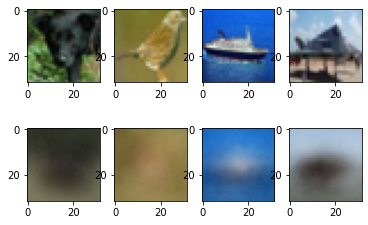

In [26]:
sample_imgs(sample_from, autoencoder, 0, 4, False)


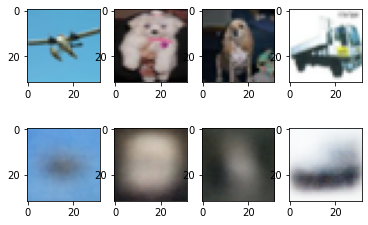

In [27]:
sample_imgs(X_train, autoencoder, 0, 4, False)

In [28]:
import os.path

savefile = ruta+"/"+nombre+".h5"

if not os.path.isfile(savefile):
    autoencoder.save(savefile)
else:
    print("Ya hay un modelo guardado en "+savefile)

In [29]:
#autoencoder.load_weights("autoencoder/autoencoder.h5")